# 신용정보 EDA

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = 'C:/Windows/Fonts/NanumGothic.ttf' 
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

## 데이터 로드

In [2]:
import pandas as pd
import os
from glob import glob

folder_train_path = '../dataset/train/2.신용정보/'
folder_test_path = '../dataset/test/2.신용정보/'

parquet_train_files = glob(os.path.join(folder_train_path, '*.parquet'))
parquet_test_files = glob(os.path.join(folder_test_path, '*.parquet'))

credit_df = pd.DataFrame()
credit_test_df = pd.DataFrame()

for file in parquet_train_files:
    df = pd.read_parquet(file, engine='fastparquet')
    credit_df = pd.concat([credit_df, df], ignore_index=True)
    print(f"✅ File: {file} Completed!")

print(f"🔹 Shape : {credit_df.shape}")

print("=" * 30)

for file in parquet_test_files:
    df = pd.read_parquet(file, engine='fastparquet')
    credit_test_df = pd.concat([credit_test_df, df], ignore_index=True)
    print(f"✅ File: {file} Completed!")

print(f"🔹 Shape : {credit_test_df.shape}")


✅ File: ../dataset/train/2.신용정보\201807_train_신용정보.parquet Completed!
✅ File: ../dataset/train/2.신용정보\201808_train_신용정보.parquet Completed!
✅ File: ../dataset/train/2.신용정보\201809_train_신용정보.parquet Completed!
✅ File: ../dataset/train/2.신용정보\201810_train_신용정보.parquet Completed!
✅ File: ../dataset/train/2.신용정보\201811_train_신용정보.parquet Completed!
✅ File: ../dataset/train/2.신용정보\201812_train_신용정보.parquet Completed!
🔹 Shape : (2400000, 42)
✅ File: ../dataset/test/2.신용정보\201807_test_신용정보.parquet Completed!
✅ File: ../dataset/test/2.신용정보\201808_test_신용정보.parquet Completed!
✅ File: ../dataset/test/2.신용정보\201809_test_신용정보.parquet Completed!
✅ File: ../dataset/test/2.신용정보\201810_test_신용정보.parquet Completed!
✅ File: ../dataset/test/2.신용정보\201811_test_신용정보.parquet Completed!
✅ File: ../dataset/test/2.신용정보\201812_test_신용정보.parquet Completed!
🔹 Shape : (600000, 42)


## 데이터 전처리

In [3]:
import numpy as np

def optimize_numeric_types(df, verbose=True):
    """
    DataFrame의 수치형(int, float) 컬럼을 숫자 범위에 맞춰 다운캐스팅하여 메모리를 최적화
    
    Parameters:
    - df (pd.DataFrame): 입력 데이터프레임
    - verbose (bool): 최적화 전후 메모리 사용량 출력 여부

    Returns:
    - pd.DataFrame: 최적화된 데이터프레임
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2 # MB단위로 변환
    
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_type = df[col].dtypes
        
        if np.issubdtype(col_type, np.integer):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if c_min >= 0:
                if c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col].astype(np.uint64)
            else:
                if np.iinfo(np.int8).min <= c_min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif np.iinfo(np.int16).min <= c_min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif np.iinfo(np.int32).min <= c_min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
                    
        elif np.issubdtype(col_type, np.floating):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if np.finfo(np.float16).min <= c_min and c_max <= np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif np.finfo(np.float32).min <= c_min and c_max <= np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    
    if verbose:
        print(f"🔹 메모리 사용량: {start_mem:.2f} MB → {end_mem:.2f} MB  ({100*(start_mem-end_mem)/start_mem:.1f}% 감소)")
    
    return df

In [4]:
credit_df = optimize_numeric_types(credit_df)
credit_test_df = optimize_numeric_types(credit_test_df)

🔹 메모리 사용량: 1673.25 MB → 1174.29 MB  (29.8% 감소)
🔹 메모리 사용량: 417.16 MB → 292.42 MB  (29.9% 감소)


In [5]:
object_columns = credit_df.select_dtypes(include=['object']).columns
object_columns

Index(['ID', '자발한도감액횟수_R12M', '한도증액횟수_R12M', '카드론동의여부', 'RV전환가능여부',
       '한도심사요청건수'],
      dtype='object')

In [6]:
unique_values = {col: credit_df[col].unique() for col in object_columns if col != 'ID'}
unique_values

{'자발한도감액횟수_R12M': array(['0회', '1회', '2회'], dtype=object),
 '한도증액횟수_R12M': array(['0회', '1회이상'], dtype=object),
 '카드론동의여부': array(['Y', 'N'], dtype=object),
 'RV전환가능여부': array(['N', 'Z', None], dtype=object),
 '한도심사요청건수': array(['0회', '1회이상'], dtype=object)}

In [7]:
unique_test_values = {col: credit_test_df[col].unique() for col in object_columns if col != 'ID'}
unique_test_values

{'자발한도감액횟수_R12M': array(['0회', '1회', '2회'], dtype=object),
 '한도증액횟수_R12M': array(['0회', '1회이상'], dtype=object),
 '카드론동의여부': array(['N', 'Y'], dtype=object),
 'RV전환가능여부': array(['Z', 'N', None], dtype=object),
 '한도심사요청건수': array(['0회', '1회이상'], dtype=object)}

In [8]:
credit_df['RV전환가능여부'] = credit_df['RV전환가능여부'].fillna('Unknown')
credit_test_df['RV전환가능여부'] = credit_test_df['RV전환가능여부'].fillna('Unknown')

for col in unique_values:
    credit_df[col] = credit_df[col].astype('category')
    credit_test_df[col] = credit_test_df[col].astype('category')

In [9]:
int_columns = credit_df.select_dtypes(include=['integer']).columns
int_columns

Index(['기준년월', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액',
       '자발한도감액금액_R12M', '자발한도감액후경과월', '강제한도감액횟수_R12M', '강제한도감액금액_R12M',
       '강제한도감액후경과월', '한도증액금액_R12M', '한도증액후경과월', '상향가능한도금액', '상향가능CA한도금액',
       '월상환론상향가능한도금액', '일시불ONLY전환가능여부', '카드이용한도금액_B1M', '카드이용한도금액_B2M',
       '특별한도보유여부_R3M', '연체감액여부_R3M', '한도요청거절건수', '한도심사요청후경과월', '한도심사거절후경과월',
       '시장단기연체여부_R6M', '시장단기연체여부_R3M', '시장연체상환여부_R6M', '시장연체상환여부_R3M',
       'rv최초시작후경과일'],
      dtype='object')

In [10]:
int_unique_values = {col: credit_df[col].unique() for col in int_columns if col != '기준년월'}
int_unique_values

{'최초한도금액': array([    0, 10000, 35113, ..., 40384, 33947, 43254], dtype=uint16),
 '카드이용한도금액': array([ 19354,   9996,  88193, ..., 210990, 209137, 176500], dtype=uint32),
 'CA한도금액': array([ 7270,  5718, 35207, ..., 63082, 63300, 49956], dtype=uint32),
 '일시상환론한도금액': array([    0, 41996, 48000, ..., 89976, 78173, 41077], dtype=uint32),
 '월상환론한도금액': array([     0,  90611, 155020, ...,  94626, 230572, 146746], dtype=uint32),
 '자발한도감액금액_R12M': array([0, 1, 2], dtype=uint8),
 '자발한도감액후경과월': array([12, 11,  0,  1,  2,  3,  4], dtype=uint8),
 '강제한도감액횟수_R12M': array([0, 1, 4, 3, 2], dtype=uint8),
 '강제한도감액금액_R12M': array([0, 1, 6, 2, 7, 4, 9], dtype=uint8),
 '강제한도감액후경과월': array([12,  8,  1,  9,  0,  6,  2,  3,  4, 10,  7,  5, 11], dtype=uint8),
 '한도증액금액_R12M': array([0, 1, 2, 3], dtype=uint8),
 '한도증액후경과월': array([12,  3,  7, 10,  9,  5,  8,  6,  1,  0,  2, 11,  4], dtype=uint8),
 '상향가능한도금액': array([ 0,  4,  3,  8, 10,  7,  6,  9,  5, 11, 12,  2, 13, 14, 18, 15, 16,
        17], dtype=uint8),
 '상향가

In [11]:
# 개수가 0개이거나 1개인 column을 제거
drop_cols = [col for col in int_unique_values if credit_df[col].nunique() <= 1]
print(f"column 수 : {len(drop_cols)}")
drop_cols

column 수 : 1


['시장연체상환여부_R3M']

In [12]:
for col in drop_cols:
    credit_df = credit_df.drop(col, axis=1)
    credit_test_df = credit_test_df.drop(col, axis=1)

In [13]:
float_columns = credit_df.select_dtypes(include=['float16', 'float32']).columns
float_columns

Index(['CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV신청일자',
       'RV약정청구율', 'RV최소결제비율'],
      dtype='object')

In [14]:
float_unique_values = {col: credit_df[col].unique() for col in float_columns}
float_unique_values

{'CA이자율_할인전': array([23.   , 14.8  , 22.02 , 14.664, 14.22 , 14.67 , 14.66 , 15.15 ,
        16.98 , 14.64 , 14.81 , 18.95 , 14.86 , 15.125, 19.08 , 19.98 ,
        14.68 , 19.03 , 19.05 , 16.88 , 14.65 , 19.95 , 14.84 , 19.94 ,
        21.95 , 19.   , 17.83 , 15.09 , 14.69 , 15.945, 15.08 , 15.195,
        19.97 , 14.82 , 14.61 , 21.75 , 14.625, 14.7  , 15.16 , 15.1  ,
        16.97 , 22.1  , 16.89 , 16.92 , 15.12 , 14.85 , 18.94 , 14.88 ,
        15.086, 14.71 , 14.805, 14.836, 15.11 , 17.98 , 14.89 , 14.73 ,
        17.   , 16.94 , 15.97 , 16.9  , 14.78 , 18.02 , 14.83 , 17.88 ,
        15.95 , 19.06 , 18.1  , 14.77 , 17.92 , 20.   , 21.9  , 14.875,
        14.87 , 21.72 , 17.86 , 16.95 , 19.19 , 18.   , 14.91 , 17.94 ,
        18.03 , 14.63 , 21.77 , 19.9  , 18.98 , 14.62 , 14.72 , 17.03 ,
        15.07 , 15.96 , 16.84 , 17.05 , 14.695, 22.98 , 15.92 , 17.9  ,
        14.586, 15.13 , 15.94 , 21.78 , 14.766, 16.86 , 14.9  , 21.98 ,
        21.92 , 17.1  , 18.8  , 18.97 , 15.2  , 21.

In [15]:
# datetime 형식으로 변환
credit_df['RV신청일자'] = pd.to_datetime(credit_df['RV신청일자'], format='%Y%m%d', errors='coerce')

# 기준일
today = pd.to_datetime('2019-01-01')

new_cols = pd.DataFrame({
    'RV신청년도': credit_df['RV신청일자'].dt.year,
    'RV신청월': credit_df['RV신청일자'].dt.month,
    'RV신청일': credit_df['RV신청일자'].dt.day,
    'RV신청_경과일수': (today - credit_df['RV신청일자']).dt.days,
})

credit_df = pd.concat([credit_df, new_cols], axis=1)
credit_df = credit_df.drop(columns=['RV신청일자'])

credit_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 44 columns):
 #   Column          Dtype   
---  ------          -----   
 0   기준년월            uint32  
 1   ID              object  
 2   최초한도금액          uint16  
 3   카드이용한도금액        uint32  
 4   CA한도금액          uint32  
 5   일시상환론한도금액       uint32  
 6   월상환론한도금액        uint32  
 7   CA이자율_할인전       float16 
 8   CL이자율_할인전       float16 
 9   RV일시불이자율_할인전    float16 
 10  RV현금서비스이자율_할인전  float16 
 11  RV약정청구율         float16 
 12  RV최소결제비율        float16 
 13  자발한도감액횟수_R12M   category
 14  자발한도감액금액_R12M   uint8   
 15  자발한도감액후경과월      uint8   
 16  강제한도감액횟수_R12M   uint8   
 17  강제한도감액금액_R12M   uint8   
 18  강제한도감액후경과월      uint8   
 19  한도증액횟수_R12M     category
 20  한도증액금액_R12M     uint8   
 21  한도증액후경과월        uint8   
 22  상향가능한도금액        uint8   
 23  상향가능CA한도금액      uint8   
 24  카드론동의여부         category
 25  월상환론상향가능한도금액    uint8   
 26  RV전환가능여부        category
 27  일시불ONLY전환가능여

In [16]:
# datetime 형식으로 변환
credit_test_df['RV신청일자'] = pd.to_datetime(credit_test_df['RV신청일자'], format='%Y%m%d', errors='coerce')

# 기준일
today = pd.to_datetime('2019-01-01')

new_cols = pd.DataFrame({
    'RV신청년도': credit_test_df['RV신청일자'].dt.year,
    'RV신청월': credit_test_df['RV신청일자'].dt.month,
    'RV신청일': credit_test_df['RV신청일자'].dt.day,
    'RV신청_경과일수': (today - credit_test_df['RV신청일자']).dt.days,
})

credit_test_df = pd.concat([credit_test_df, new_cols], axis=1)
credit_test_df = credit_test_df.drop(columns=['RV신청일자'])

credit_test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 44 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   기준년월            600000 non-null  uint32  
 1   ID              600000 non-null  object  
 2   최초한도금액          600000 non-null  uint16  
 3   카드이용한도금액        600000 non-null  uint32  
 4   CA한도금액          600000 non-null  uint32  
 5   일시상환론한도금액       600000 non-null  uint32  
 6   월상환론한도금액        600000 non-null  uint32  
 7   CA이자율_할인전       600000 non-null  float16 
 8   CL이자율_할인전       600000 non-null  float16 
 9   RV일시불이자율_할인전    600000 non-null  float16 
 10  RV현금서비스이자율_할인전  600000 non-null  float16 
 11  RV약정청구율         600000 non-null  float16 
 12  RV최소결제비율        600000 non-null  float16 
 13  자발한도감액횟수_R12M   600000 non-null  category
 14  자발한도감액금액_R12M   600000 non-null  uint8   
 15  자발한도감액후경과월      600000 non-null  uint8   
 16  강제한도감액횟수_R12M   600000 non-null  uint8

In [17]:
nan_columns = credit_df.columns[credit_df.isnull().any()].tolist()
nan_columns

['RV신청년도', 'RV신청월', 'RV신청일', 'RV신청_경과일수']

In [18]:
for col in nan_columns:
    credit_df[col] = credit_df[col].fillna(9999.).astype('float16')
    credit_test_df[col] = credit_test_df[col].fillna(9999.).astype('float16')

## Feature Selection

In [19]:
segment_df = pd.read_parquet('../dataset/train/member.parquet', engine='fastparquet')
segment_df = segment_df[['ID', '기준년월', 'Segment']]

credit_df = credit_df.merge(segment_df, on=['ID', '기준년월'], how='left')

In [20]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importance(X, y, importance_type='gain', plot_top_n=30):
    """
    LightGBM을 이용해 Feature Importance를 계산하고, 상위 feature를 시각화합니다.
    
    Parameters:
    - X (pd.DataFrame): feature 데이터
    - y (pd.Series or np.array): target 데이터
    - importance_type (str): 'gain' 또는 'split' (중요도 기준)
    - plot_top_n (int): 중요도가 높은 feature 몇 개를 plot할지
    - random_state (int): seed 고정

    Returns:
    - feature_importance_df (pd.DataFrame): feature importance 데이터프레임
    - model (lgb.Booster): 학습된 LightGBM 모델
    """

    # LightGBM 데이터셋 구성
    lgb_train = lgb.Dataset(X, label=y)

    # LightGBM 기본 파라미터 (가볍게 학습)
    params = {
        'objective': 'multiclass',   # 다중 클래스 분류
        'num_class': 5,  # 클래스 수 자동 지정
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',   # 다중 클래스 로지 손실
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }

    # 빠르게 학습 (에포크 100회로 제한)
    model = lgb.train(params, lgb_train, num_boost_round=100)

    # Feature Importance 가져오기
    importance = model.feature_importance(importance_type=importance_type)
    feature_names = X.columns

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # 시각화
    top_features = feature_importance_df.head(plot_top_n)
    
    plt.figure(figsize=(10, max(6, plot_top_n // 2)))
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Top {plot_top_n} Feature Importance ({importance_type})')
    plt.tight_layout()
    plt.show()

    return feature_importance_df, model


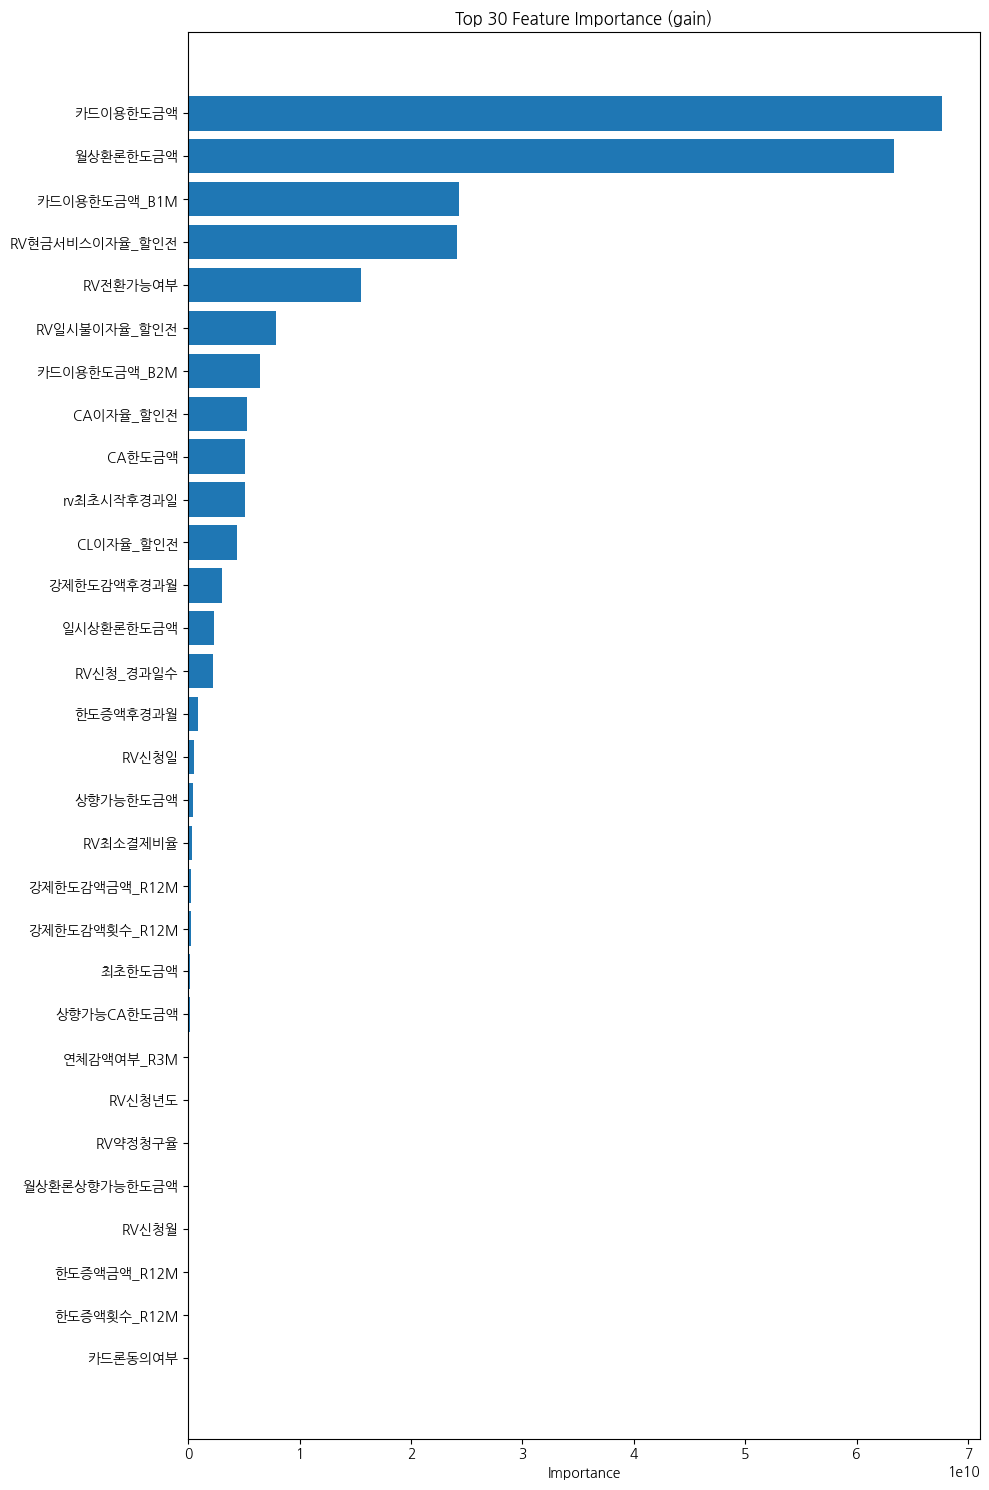

In [21]:
X = credit_df.drop(columns=['ID', '기준년월', 'Segment'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(credit_df['Segment'])

importance_df, model = get_feature_importance(X, y, importance_type='gain', plot_top_n=30)

- `rv최초시작후경과일`이 Top 1 Feature
    - 그러나 결측치가 너무 많음.
    - NaN은 리볼빙을 사용하지 않는 고객이 많다는 의미.
    - 모델이 "리볼빙 사용 여부"만 보고 예측하려고 한다면, 실제 비즈니스 해석력이 떨어질 수 있음
    - "리볼빙을 했는가" + "얼마나 오래 사용했는가"를 동시에 담고 있는 복합 feature라고 결론
    - "RV사용여부"라는 새로운 Feature를 생성

In [22]:
def select_top_features(importance_df, X, top_percent=0.3):
    """
    중요도 데이터프레임에서 상위 top_percent 비율만큼 feature를 선택하여 데이터셋 추출

    Parameters:
    - importance_df (pd.DataFrame): feature와 importance를 가진 데이터프레임
    - X (pd.DataFrame): 원본 feature 데이터셋
    - top_percent (float): 상위 몇 %를 선택할지 (기본 30%)

    Returns:
    - X_top (pd.DataFrame): 상위 feature만 선택된 데이터프레임
    - selected_features (list): 선택된 feature 리스트
    """
    n_features = int(len(importance_df) * top_percent)
    selected_features = importance_df['feature'].iloc[:n_features].tolist()
    X_top = X[selected_features]
    return X_top, selected_features

In [23]:
X_top, selected_features = select_top_features(importance_df, X, top_percent=0.3)
print(f"🔹 선택된 feature 수: {len(selected_features)}")
print(f"🔹 선택된 feature: {selected_features}")

🔹 선택된 feature 수: 12
🔹 선택된 feature: ['카드이용한도금액', '월상환론한도금액', '카드이용한도금액_B1M', 'RV현금서비스이자율_할인전', 'RV전환가능여부', 'RV일시불이자율_할인전', '카드이용한도금액_B2M', 'CA이자율_할인전', 'CA한도금액', 'rv최초시작후경과일', 'CL이자율_할인전', '강제한도감액후경과월']


In [26]:
def plot_feature_correlation(X_top, threshold=0.8):
    """
    상위 feature들 간의 상관계수 행렬을 시각화하고, 
    threshold 이상인 feature쌍을 출력

    Parameters:
    - X_top (pd.DataFrame): 상위 feature 데이터프레임
    - threshold (float): 높은 상관관계로 간주할 기준
    """
    # 수치치형 feature만 선택
    numeric_features = X_top.select_dtypes(include=['int', 'float'])
    corr_matrix = numeric_features.corr()

    # 상관관계 히트맵 그리기
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Top Features')
    plt.show()

    # threshold 이상인 feature 쌍 출력
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if high_corr_pairs:
        print(f"\n상관계수 {threshold} 이상인 feature 쌍:")
        for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"🔹{f1} vs {f2}: 상관계수 = {corr:.3f}")
    else:
        print(f"\n상관계수 {threshold} 이상인 feature 쌍이 없습니다.")

In [27]:
# 상관계수 0.8 이상인 feature 쌍을 시각화
plot_feature_correlation(X_top, threshold=0.8)

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x1000 with 0 Axes>

In [29]:
filtered_credit_df = credit_df[['ID', '기준년월'] + X_top.columns.tolist()]
filtered_credit_df.to_parquet('../dataset/train/credit.parquet', engine='fastparquet', index=False)

filtered_credit_test_df = credit_test_df[['ID', '기준년월'] + X_top.columns.tolist()]
filtered_credit_test_df.to_parquet('../dataset/test/credit.parquet', engine='fastparquet', index=False)